In [1]:
import sys

sys.path.insert(0, "..")
from src.settings import StyleSettings
from src.data.data_tools import StyleDataset
import numpy as np
import seaborn as sns
import math


# Load the data

In [2]:
settings = StyleSettings()
traindataset = StyleDataset([settings.trainpath])
testdataset = StyleDataset([settings.testpath])


We have 419 batches in the dataset

In [3]:
len(traindataset) // 32


419

In [4]:
x, y = traindataset[42]
x, y


('Lace is an openwork fabric , patterned with open holes in the work , made by machine or by hand.',
 'wiki')

Every batch is a `Tuple[str, str]` of a sentence and a label. We can see this is a classification task.
The task is, to classify sentences in four categories.
Lets build a vocabulary by copy-pasting the code we used before

In [5]:
from src.models import tokenizer

corpus = []
for i in range(len(traindataset)):
    x = tokenizer.clean(traindataset[i][0])
    corpus.append(x)
v = tokenizer.build_vocab(corpus, max=20000)
len(v)


2022-07-04 17:44:57.529 | INFO     | src.models.tokenizer:build_vocab:27 - Found 19306 tokens


19308

We need to cast the labels to an integers. You can use this dictionary to do so:

In [6]:
d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
d[y]


2

# Question 1
Figure out, for every class, what accuracy you should expect if the model would guess blind on the train set

In [7]:
#Query 1
import collections
count_labels = collections.Counter([traindataset[i][1] for i in range(len(traindataset))])
{v: count_labels[v] for v in count_labels}


{'humor': 4213, 'wiki': 4181, 'proverbs': 831, 'reuters': 4186}

In [8]:
#Query 2
import collections
count_labels = collections.Counter([traindataset[i][1] for i in range(len(traindataset))])
{v: count_labels[v] / len(traindataset) for v in count_labels}

{'humor': 0.31414510476474533,
 'wiki': 0.31175900380284843,
 'proverbs': 0.06196405935426143,
 'reuters': 0.3121318320781448}

Reflect on what you see. What does this mean? What implications does this have? Why is that good/bad?
Are there things down the line that could cause a problem?

## <span style="color:Green">*Toelichting student*</span> 

Op basis van de uitkomsten van query 1 blijkt dat de categorieën 'humor', 'wiki' en 'reuters' in de traindataset een nagenoeg gelijk aantal observaties bevat. De categorie 'proverbs' bevat daarentegen een aanzienlijk lager aantal observaties. 

Middels query 2 is per categorie berekend hoe groot de kans is dat een willekeurige observatie toebehoort tot een specifieke categorie. Conform de uitkomsten van query 1 blijkt dat de kans dat een observatie afkomstig is van de categorieën 'humor'(31,4%), 'wiki'(31,2%) en 'reuters'(31,2%) bijna gelijk is, terwijl de kans dat een willekeurige observatie toebehoort tot de categorie 'proverbs' met 6,2% veel lager is. Bij een normale verdeling van de data zou iedere categorie een gelijke kans hebben (namelijk 25%) dat een willekeurige observatie van een specifieke categorie afkomstig is. 

In dit geval bevat de traindataset geen normale verdeling. Een nadeel hiervan is dat het model voor de categorie 'Proverbs' minder voorbeelden beschikbaar heeft om op te trainen. Hierdoor ontstaat het risico dat, gezien het beperkte aantal observaties, het model minder goed in staat is om 'proverbs' zinnen te herkennen waardoor het model minder accuraat wordt. 

# Question 2 : Implement a preprocessor

We can inherit from `tokenizer.Preprocessor`
Only thing we need to adjust is the `cast_label` function.
 
- create a StylePreprocessor class
- inherit from Preprocessor
- create a new cast_label function for this dataset

In [9]:
class StylePreprocessor(tokenizer.Preprocessor):
    def cast_label(self, label: str) -> int:
        if label in d.keys():
            return d[label]

To test the preprocessor:

In [10]:
preprocessor = StylePreprocessor(max=100, vocab=v, clean=tokenizer.clean)
preprocessor([(x, y)])


(tensor([[4929,  854,   32,   15,  499,   21, 8496,  890]], dtype=torch.int32),
 tensor([2]))

# Set up the model
We can re-use the BaseDatastreamer

In [11]:
from src.data import data_tools

trainstreamer = data_tools.BaseDatastreamer(
    dataset=traindataset, batchsize=32, preprocessor=preprocessor
).stream()
teststreamer = data_tools.BaseDatastreamer(
    dataset=testdataset, batchsize=32, preprocessor=preprocessor
).stream()


In [12]:
x, y = next(trainstreamer)
x.shape, y


(torch.Size([32, 29]),
 tensor([2, 0, 0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 2, 1, 2, 2, 1, 3, 0, 2, 2, 0, 0, 1,
         0, 2, 0, 0, 2, 0, 1, 1]))

## Question 3 : Metrics, loss
Select proper metrics and a loss function.

Bonus: implement an additional metric function that is relevant for this case.

In [13]:
from src.models import metrics
import torch

metrics = [metrics.F1Score(), metrics.Accuracy()] ## Op basis van theorie beste metrics + onderbouwing toevoegen.
loss_fn = torch.nn.CrossEntropyLoss()

## <span style="color:Green">*Toelichting student*</span> 

Op te bepalen welke metrices het meest geschikt zijn voor deze NLP-dataset, heb ik op internet research gedaan. Op de website van [Towards data science](https://towardsdatascience.com/the-most-common-evaluation-metrics-in-nlp-ced6a763ac8b) heb ik een artikel gevonden waarin wordt beschreven dat onder andere de metrices 'Accuracy', 'Precision', 'Recall' en 'F1 Score' geschikt zijn voor het evalueren van de werking van een NLP-model. Ik het gekozen voor de metrices 'Accuracy' en 'F1 Score'. De 'Accuracy' metrics is tijdens de lessen veelvuldig gebruikt en geeft goed inzicht in de presaties van een model. De F1 score vind ik een interessante metrics omdat hierin de 'Precision' en 'Recall' gecombineerd zijn. Daarnaast heb ik in een eerder noteboek gelezen dat de F1-score bij uitstek geschikt is voor ongebalanceerde datasets. 

Aangezien de opdracht een classificatie vraagstuk betreft, heb ik gekozen om de 'CrossEntropyLoss' als loss function te implementeren. Deze functie is namelijk zeer geschikt voor classificatie vraagstukken. 

## Question 4 : Basemodel
Create a base model. It does not need to be naive; you could re-use the
NLP models we used for the IMDB.

I suggest to start with a hidden size of about 128.
Use a config dictionary, or a gin file, both are fine.

Bonus points if you create a Trax model in src.models, and even more if you add a trax training loop.

In [14]:
log_dir = settings.log_dir
from src.models import rnn

config = {
    "vocab": len(v),
    "hidden_size": 128,
    "num_layers": 3,
    "dropout": 0.1,
    "output_size": 4,
}

model = rnn.NLPmodel(config)


Set up the trainloop.

- Give the lenght of the traindataset, how many batches of 32 can you get out of it?
- If you take a short amount of train_steps (eg 25) for every epoch, how many epochs do you need to cover the complete dataset?
- What amount of epochs do you need to run the loop with trainsteps=25 to cover the complete traindataset once? 
- answer the questions above, and pick a reasonable epoch lenght

Start with a default learning_rate of 1e-3 and an Adam optimizer.

## <span style="color:Green">*Toelichting student*</span> 

In [15]:

print(f'''1. De traindataset bevat {len(traindataset)} observaties. Op basis van een batchsize van {32} observaties is het mogelijk om {round(len(traindataset)/32)} gehele batches te creëren, waarna er nog {len(traindataset)-(32*(round(len(traindataset)/32)))} losse observaties resteren. Om alle observaties te batchen zijn dus {math.ceil(len(traindataset)/32)} batches benodigd.''')
print()
print(f'''2. De gehele dataset (train- en testdataset) bevat {(len(traindataset) + len(testdataset))} observaties. Op basis van een batchsize met 32 observaties en een train_step van 25 observaties, zijn {math.ceil((len(traindataset) + len(testdataset))/(32*25))} epochs benodigd om alle observaties door het model te laten analyseren. ''')
print()
print(f'''3. De traindataset bevat {len(traindataset)} observaties. Op basis van een batchsize met 32 observaties en een train_step van 25 observaties, zijn {math.ceil(len(traindataset)/(32*25))} epochs benodigd om alle observaties door het model te laten analyseren. ''')
print()
print(f'''4. Doordat tijdens het trainen van het model enkel de observaties afkomstig uit de traindataset worden geanalyseerd, zijn {math.ceil(len(traindataset)/(32*25))} epochs voldoende om alle observaties door het model te laten analyseren. Tijdens onderdeel 6 'Tune the model' zal onder andere met aantal epochs worden geëxperimenteerd.''')

1. De traindataset bevat 13411 observaties. Op basis van een batchsize van 32 observaties is het mogelijk om 419 gehele batches te creëren, waarna er nog 3 losse observaties resteren. Om alle observaties te batchen zijn dus 420 batches benodigd.

2. De gehele dataset (train- en testdataset) bevat 16764 observaties. Op basis van een batchsize met 32 observaties en een train_step van 25 observaties, zijn 21 epochs benodigd om alle observaties door het model te laten analyseren. 

3. De traindataset bevat 13411 observaties. Op basis van een batchsize met 32 observaties en een train_step van 25 observaties, zijn 17 epochs benodigd om alle observaties door het model te laten analyseren. 

4. Doordat tijdens het trainen van het model enkel de observaties afkomstig uit de traindataset worden geanalyseerd, zijn 17 epochs voldoende om alle observaties door het model te laten analyseren. Tijdens onderdeel 6 'Tune the model' zal onder andere met aantal epochs worden geëxperimenteerd.


In [16]:
from src.training import train_model

model = train_model.trainloop(
    epochs=17,
    model=model,
    metrics=metrics,
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=25,
    eval_steps=25,
)


2022-07-04 17:44:59.958588: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-04 17:44:59.958652: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-04 17:45:02.530 | INFO     | src.data.data_tools:dir_add_timestamp:67 - Logging to ../tune/20220704-1745
100%|██████████| 25/25 [00:04<00:00,  6.06it/s]
2022-07-04 17:45:07.734 | INFO     | src.training.train_model:trainloop:164 - Epoch 0 train 1.2929 test 1.2418 metric ['0.2334', '0.4113']
100%|██████████| 25/25 [00:03<00:00,  7.05it/s]
2022-07-04 17:45:11.917 | INFO     | src.training.train_model:trainloop:164 - Epoch 1 train 1.2431 test 1.2336 metric ['0.2295', '0.3950']
100%|██████████| 25/25 [00:02<00:00, 10.19it/s]
2022-07-04 17:45:15.193 | INFO     | src.training.train_model:trainloop:164 -

Save an image from the training in tensorboard in the `figures` folder.
Explain what you are seeing.

## <span style="color:Green">*Toelichting student*</span> 

In onderstaande visual is goed zichtbaar dat het model tot aan epoch 11 zich vlot blijft ontwikkelen, waarna de leersnelheid wat afvlakt. Op basis van uitkomsten zou ik echter wel middels een experiment proberen om het aantal epochs te vergroten om vast te stellen of het model daadwerkelijk is uitgeleerd of dat het model zich nog verder kan ontwikkelen.  

<img src="../figures/TensorBoard.png">

# 5 Evaluate the basemodel
Create a confusion matrix with the code below

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'Target')]

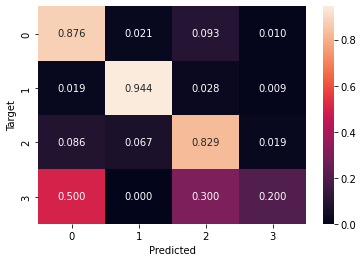

In [17]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for _ in range(10):
    X, y = next(teststreamer)
    yhat = model(X)
    yhat = yhat.argmax(dim=1)
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
plot = sns.heatmap(cfm_norm, annot=cfm_norm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")


Save this in the figures folder.
Interpret this. 

- What is going on?
- What is a good metric here?
- how is your answer to Q1 relevant here?
- Is there something you could do to fix/improve things, after you see these results?

## <span style="color:Green">*Toelichting student*</span> 

<img src="../figures/Confusion_Matrix.png">

1. In de bovenstaande matrix is weergegeven hoe goed het model presteert op de testdataset. Uit de matrix kan worden afgeleid dat het model observaties voor de categoriën 'humor'(0), 'reuters'(1) en 'wiki'(2) goed kan voorspellen. Dit blijkt uit de hoge accuracy scores van tussen de 81,0% en 98,9%. De categorie 'proverbs'(3) scoort met een accuracy van 68,8% een stuk lager. Uit de matrix blijkt dat een deel van 'proverbs' observaties zijn toegekend aan de categorie 'wiki', maar dat andersom hier slechts beperkt sprake van is. Een mogelijke verklaring hiervan betreft de ongelijke verdeling van de traindataset waardoor voor de categorie 'proverbs'(3) minder observaties beschikbaar zijn geweest om het model goed op te kunnen trainen.<br>

2. In de huidige matrix wordt de accuracy per categorie weergegeven. Afhankelijk van de doelstelling van het classificatie vraagstuk bieden de metrices 'Precision' en 'Recall' goed inzicht in de prestaties van een model. Indien een balans wordt gezocht tussen de metrices 'Precision' en 'Recall' is de 'F1 Score' een goed alternatief omdat hierin de metrices 'Precision' en 'Recall' zijn gecombineerd. Daarnaast sluit de F1-score goed aan bij de ongebalanceerde dataset. (Bron: [Toward Data Science](https://towardsdatascience.com/confusion-matrix-un-confused-1ba98dee0d7f))<br>

3. Zoals deels in antwoord 1 beschreven scoort het model op basis van de gebruikte parameters goed bij het identificeren van observaties die toebehoren tot de categoriën 0 t/m 2. Voor wat betreft categorie 3 scoort het model minder goed. Dit wordt vermoedelijk veroorzaakt doordat de trainingset minder observaties bevat voor de categorie 'proverbs'(3) dan voor de andere categorieën. Het model heeft hierdoor minder voorbeelden beschikbaar om karakteristieken te identificeren die toebehoren tot de observaties van categorie 'proverbs'(3).<br>

4. De trainingsdataset in ongelijk verdeeld doordat het aantal observaties voor de categorie 'proverbs'(3) veel lager uitvalt dan het aantal observaties voor de overige drie categoriën. Een gelijk verdeelde dataset kan de prestaties van een model verbeteren. Om een gelijk verdeelde dataset te creëren zijn grofweg twee opties mogelijk:
* Undersampling: voor de categoriën met veel observaties wordt slechts een deel van de observaties gesampled zodat het aantal observaties per categorie in de train- en testdataset nagenoeg gelijk is.
* Oversampling: voor de categorie met weinig observaties worden observaties gedupliceerd zodat een gelijk verdeelde dataset ontstaat. <br>

In onderstaande afbeelding is het principe van oversampling en undersampling weergegeven.

<img src="https://miro.medium.com/max/1400/1*P93SeDGPGw0MhwvCcvVcXA.png" />

(Bron: [Toward Data Science](https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb))




# 6 Tune the model
Don't overdo this.
More is not better.

Bonus points for things like:
- Attention layers
- Trax architecture including a functioning training loop

Keep it small! It's better to present 2 or 3 sane experiments that are structured and thought trough, than 25 random guesses. You can test more, but select 2 or 3 of the best alternatives you researched, with a rationale why this works better.

Keep it concise; explain:
- what you changed
- why you thought that was a good idea  
- what the impact was (visualise or numeric)
- explain the impact

You dont need to get a perfect score; curiousity driven research that fails is fine.
The insight into what is happening is more important than the quantity.

Keep logs of your settings;
either use gin, or save configs, or both :)
Store images in the `figures` folder.

## <span style="color:Green">*Toelichting student*</span> 

Voor het tunen van het RNN-model (zonder attention layer) heb ik een zestal experimenten uitgevoerd met in totaal 47 trainsessies om het model te verbeteren en om inzicht te krijgen wat de impact van bepaalde variabelen zijn op de werking van het model. In deze eindopdracht zijn drie experimenten met de meest interessante uitkomsten of waarvan de verwachtingen het hoogst waren, nader toegelicht in de experimenten 1 t/m 4. Per experiment en trainsessie zijn alle variabelen en de uitkomsten van het model vastgelegd in een Excel-overzicht. Bij de beschrijving van de verschillende experimenten zijn de gebruikte variabelen inclusief uitkomsten weergegeven.

Daarnaast ben ik als onderdeel van de bonusopdracht de uitdaging aangegaan om een attention layer toe te voegen aan het RNN-model om zo de toegevoegde waarde van het RNN-model te beschrijven en te visualiseren. Dit experiment is beschreven in experiment 5.

### <span style="color:Green">*Experiment 1: Batch Size*</span> 

Middels het experimenteren met de batch size heb ik geprobeerd om een optimum te vinden waarbij het model het beste presteert. Hierbij heb ik gekozen om de batch size per trainsessie te verdubbelen van een batch size met 16 observaties tot een batch size met 256 observaties. In onderstaande tabel zijn alle variabelen weergegeven die tijdens de trainsessies zijn toegepast inclusief de tijdsduur per trainsessie en de scores van het model:
<img src="../figures/Experiment_1_Batch_Size.png">

Op basis van de uitkomsten blijkt dat het model het best presteert bij een batch size met 64 observaties. De F1-score en de loss/train blijft zich bij een hogere batch size nog wel ontwikkelen, echter verslechterd de loss/test bij een hogere batch size. Vooral het verschil dat ontstaat tussen de loss/test en de loss/train is kenmerkend dat het model begint te overfitten. Tot en met een batch size van 64 observaties blijft dit verschillen beperkt, echter vanaf een batch size van 128 obeservaties wordt het verschil steeds groter. Het model wordt namelijk goed in het herkennen van de voorbeelden in de trainset en bereikt daardoor een hoge score, echter op de testset met nieuwe voorbeelden blijven de prestaties achter. 

### <span style="color:Green">*Experiment 2: Hidden Size*</span> 

Middels het experimenteren met de hidden size heb ik geprobeerd om te onderzoeken wat het effect van de hidden size is op de prestaties van het model. Mijn hypothese was dat het model bij een te grote hidden size zou gaan overfitten, omdat het model teveel gaat letten op de kleine details in de data en doordoor generiekere kenmerken mist. Bij een te kleine hidden size daarentegen worden onderscheidende kenmerken niet goed geïdentificeerd. In onderstaande tabel zijn alle variabelen weergegeven die tijdens de trainsessies zijn toegepast inclusief de tijdsduur per trainsessie en de scores van het model:
<img src="../figures/Experiment_2_Hidden_Size.png">

Op basis van de uitkomsten blijkt dat het model het best presteert bij een hidden size van 128. Een betere score wordt nog behaald bij een hidden size van 1028, echter is het verschil tussen de loss/test en de loss/train dermate groot dat ik zou opteren voor de een hidden size van 128, zodat het model meer voorspelbaar presteert zonder dat daarbij het risico ontstaat op overfitting. 

### <span style="color:Green">*Experiment 3: Epoch*</span>
Op basis van de voorgaande experimenten bleek dat het model nog niet was uitgeleerd. Om die reden heb ik besloten om diverse experimenten te gaan uitvoeren waarbij het aantal epochs stapsgewijs worden vergroot. In onderstaande tabel zijn alle variabelen weergegeven die tijdens de trainsessies zijn toegepast inclusief de tijdsduur per trainsessie en de scores van het model: 
<img src="../figures/Experiment_3_Epoch.png">

Op basis van de uitkomsten van het model blijkt dat een hogere epoch slechts in beperkte mate invloed heeft op de prestaties van het model. De laagste lost/test score wordt bereikt bij een epoch van 25, echter zou mijn voorkeur uitgaan naar een epoch van 17 doordat het verschil tussen de loss/test en de loss/train bij dit epoch aantal beperkt blijft terwijl bij een epoch van 25 een aanzienlijk verschil onstaat. In onderstaande afbeelding zijn de uitkomsten weergegevan van trainsessie met 45 epochs:

<img src="../figures/Experiment_3_Output.png">

Hieruit blijkt inderdaad dat de prestaties van het model (o.b.v. de loss/test, Accuracy en F1 score) na 17-20 epochs afzwakt of zelfs slechter gaat presteren terwijl de loss/train zich verder blijft verbeteren. Dit wordt veroorzaakt doordat het model bij een hogere epoch dezelfde voorbeelden krijgt aangeboden die het model herkent en daardoor een goede voorspelling kan geven. Opmerkelijk is dat de learning_rate gedurende de traincycles automatisch wordt aangepast. Deze aanpassing wordt veroorzaakt door de schedular die in het models is geïmplementeerd en ervoor zorgt dat de learning_rate wordt aangepast nadat het model onvoldoende leert na verloop van tijd.   


### <span style="color:Green">*Experiment 4: Optimizers & Learning rate*</span> 

Voor het laatste experiment met het RNN-model zonder Attention-Layer heb ik besloten om verschillende optimizers te testen met daarbij een wisselende learning rate. Eenzelfde soort experiment heb ik uitgevoerd op de MNIST-Fashion dataset waarbij de Adam, RMSprop en Adagrad optimizers nagenoeg gelijk presteerden. Doordat dit een ander type dataset betreft waarvoor een ander model wordt toegepast, verwacht ik andere uitkomsten tussen de verschillende modellen. In onderstaande tabel zijn alle variabelen weergegeven die tijdens de trainsessie zijn toegepast inclusief de tijdsduur per trainsessie en de scores van het model: 
<img src="../figures/Experiment_4_Optimizers.png">

Om de uitkomsten van dit experiment beter te visualiseren, heb ik besloten om voor de Loss/test, Accuracy, en F1-Score matrixen op te stellen waarin de uitkomsten zijn gevisualiseerd.

#### Matrix Loss/Test
<img src="../figures/Experiment_4_Output_Loss_Test.png">

#### Matrix Accuracy
<img src="../figures/Experiment_4_Output_Accuracy.png">

#### Matrix F1-Score
<img src="../figures/Experiment_4_Output_F1_Score.png">


Op basis van de hierboven weergegeven matrices blijkt dat wederom de optimizers Adam, RMSprop en Adagrad het best presteren, maar dat de optimizers zeer gevoelig zijn voor aanpassingen in de learning rate. Hieronder een korte analyse per optimizer.

* Adam

De optimizer Adam scoort overall het best. Een learning rate van 1,00E-02  resulteert in de hoogte score met een lost/test van 28%, een Accuracy van 89% en een F1-score van 87%. Bij een lagere learning rate scoort het model ronduit slecht.

* SGD

De optimizer SGD scoort het slechts van de vier geteste optimizers waarbij het model bij geen enkele learning rate in staat is om de data goed te classificeren, zelfs niet op basis van traindataset. De Loss/test uitkomsten tonen weinig variatie bij een wijziging van de learning rate.

* Adagrad

De Adagrad optimizer geeft bij een learning rate van 1,00E-01 de beste resultaten weer van de vier geteste optimizers en scoort bij een learning rate van 1,00E-02 zelf nog iets beter. Bij een learning rate van 1,00E-03 t/m 1,00E-05 scoort het model juist weer beduidend slechter.    

* RMSprop

De uitkomsten van de RMSprop optimizer zijn zeer wisselend. Bij een learning rate van 1,00E-01 presteert het model ondermaats, terwijl de optimizer bij een learning rate van 1,00E-02 t/m 1,00E-03 juist weer goed scoort met mooie resultaten. 

### <span style="color:Green">*Experiment 5: RNN-model met attention layer*</span> 

Tijdens het laatste model is een experiment uitgevoerd waarbij het RRN-model is geupgrade met een attention layer. De code die is uitgebruikt voor dit experiment is hieronder weergegeven. 

In [18]:
from src.data import data_tools

trainstreamer = data_tools.BaseDatastreamer(
    dataset=traindataset, batchsize=64, preprocessor=preprocessor
).stream()
teststreamer = data_tools.BaseDatastreamer(
    dataset=testdataset, batchsize=64, preprocessor=preprocessor
).stream()

In [19]:
log_dir = settings.log_dir
from src.models import rnn

config = {
    "vocab": len(v),
    "hidden_size": 128,
    "num_layers": 3,
    "dropout": 0.1,
    "output_size": 4,
}

model = rnn.AttentionNLP(config)

In [20]:
from src.training import train_model

model = train_model.trainloop(
    epochs=25,
    model=model,
    metrics=metrics,
    optimizer=torch.optim.Adam,
    learning_rate=1e-2,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=25,
    eval_steps=25,
)

2022-07-04 17:45:56.493 | INFO     | src.data.data_tools:dir_add_timestamp:67 - Logging to ../tune/20220704-1745
100%|██████████| 25/25 [00:04<00:00,  6.17it/s]
2022-07-04 17:46:01.949 | INFO     | src.training.train_model:trainloop:164 - Epoch 0 train 1.3208 test 0.9569 metric ['0.4834', '0.6388']
100%|██████████| 25/25 [00:03<00:00,  6.31it/s]
2022-07-04 17:46:07.294 | INFO     | src.training.train_model:trainloop:164 - Epoch 1 train 0.7701 test 0.7401 metric ['0.5839', '0.7656']
100%|██████████| 25/25 [00:03<00:00,  6.97it/s]
2022-07-04 17:46:12.221 | INFO     | src.training.train_model:trainloop:164 - Epoch 2 train 0.6406 test 0.5009 metric ['0.6898', '0.8387']
100%|██████████| 25/25 [00:03<00:00,  6.83it/s]
2022-07-04 17:46:17.397 | INFO     | src.training.train_model:trainloop:164 - Epoch 3 train 0.5297 test 0.5215 metric ['0.6440', '0.8281']
100%|██████████| 25/25 [00:04<00:00,  5.65it/s]
2022-07-04 17:46:23.095 | INFO     | src.training.train_model:trainloop:164 - Epoch 4 train

#### <span style="color:Green">*Uitkomsten experiment*</span> 

Voor het RNN-model met attention layer zijn de meest succesvolle variabelen gebruikt op basis van de eerder beschreven experimenten. Doordat het model in eerste instantie slechter scoorde dat het RNN-model zónder attention layer, heb ik besloten om meerdere runs te draaien om een goede indruk te verkrijgen van het model. Doordat er gebruik wordt gemaakt van een streamer, wordt bij iedere run namelijk een andere dataset aangeboden waardoor het model, op basis van dezelfde variabelen, anders kan presteren.

<img src="../figures/Experiment_5_Attention_Layer.png">

Op basis van bovenstaande uitkomsten is goed inzichtelijk dat het model een mooie score heeft behaald, maar op basis van de Loss/test score nog minder presteert dan het model zonder de attention layer.   Een mogelijke uitkomst hiervan kan zijn dat het model met attention layer andere variabelen nodig heeft om optimaal te presteren. Derhalve heb ik besloten om op basis van de ervaringen van de voorgaande analyse nog een vijftien-tal experimenten uit te voeren om een betere score te bereiken. In onderstaande tabel zijn alle variabelen weergegeven die tijdens de trainsessies zijn toegepast inclusief de tijdsduur per trainsessie en de scores van het model:

<img src="../figures/Experiment_5_Attention_Layer_extra.png">

Kijkend naar de loss/test, accuracy en F1-score is het gelukt om het model nog net iets beter te laten presteren. De uitkomsten zijn in bovenstaande tabel in groen gemarkeerd.


### <span style="color:Green">*Conclusie*</span> 

De hiervoor beschreven experimenten heb ik als zeer leerzaam ervaren. Middels het handmatig 'tunen' van een model heb ik een goed beeld verkregen welke invloed parameters kunnen hebben op een model. Het gestructureerd vastleggen van de gebruikte parameters in combinatie met de visualisaties in TenserBoard zorgen ervoor dat de veranderingen in uitkomsten goed geïntepreteerd kunnen worden en daarbij beter kan worden bijgestuurd tijdens de experimenten. Vooral de uitkomsten van het experimenten met de learning rate en optimizers vond ik interessant doordat goed wordt weergegeven hoe gevoelig een model kan zijn voor kleine wijzigingen. Wel had ik verwacht dat het toevoegen van een attention layer een grotere impact zou hebben op de werking van het model. Een kleine disclaimer hierbij is dat ik heb gemerkt dat de uitkomsten van de experimenten tussentijds kunnen verschillen, doordat de input per run varieert.